# Use-Case: Machine Learning based Leakage Detection

Anomaly detection such as leakage detection is a classic but often non-trivial task in WDN operation. With traditional (model-based) methods reaching their limits, Machine Learning offers promising solutions.

#### Outline 
This notebook demonstrates how EPyT-Flow and EPyT-Control can be utilized to create a scenario containing several leakages that have to be detected.
Here, we use a simple Machine Learning based leakage detector that is already included in EPyT-Flow.
It consists of the following steps:
1. Create a new (realistic) scenario.
2. Add some leakages to the scenario.
3. Create a simple Machine Learning based leakage detector.
4. Evaluate the leakage detector.

In [63]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ImportWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import epyt_flow
import pandas as pd

from sklearn.metrics import mutual_info_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from epyt_flow.data.networks import load_ltown
from epyt_flow.data.benchmarks import load_leakdb_scenarios
from epyt_flow.simulation import ScenarioSimulator
from epyt_flow.simulation.events import AbruptLeakage, IncipientLeakage
from epyt_flow.utils import to_seconds, time_points_to_one_hot_encoding
from epyt_control.signal_processing import SensorInterpolationDetector

In [64]:
# Assume that we know which specific nodes we want to watch:
def calc_Relevance (node_pressures, relevant_index):
    relevances = {}
    for i in range(len(node_pressures)):
        if i != relevant_index:
            relevances[i] = mutual_info_score(node_pressures[relevant_index], node_pressures[i])
    return relevances

# calcuate relevance over all nodes:

def calc_Relevances (node_pressures):
    relevances = {}
    for i in range(len(node_pressures)):
        for j in range(i + 1, len(node_pressures)):
            m_i_score = mutual_info_score(node_pressures[i], node_pressures[j])
            if i not in relevances:
                relevances[i] = m_i_score
            else:
                relevances[i] += m_i_score
            if j not in relevances:
                relevances[j] = m_i_score
            else:
                relevances[j] += m_i_score
    return relevances
    
def calc_Redundance (x_pressures, sensor_pressures):
    redundancy = 0
    for pressure in sensor_pressures:
        redundancy += mutual_info_score(x_pressures, pressure)
    redundancy /= len(sensor_pressures)
    return redundancy

In [65]:
def calc_sensor_placement(node_pressures, num_sensors = 15): # do we know which nodes we want to monitor? junctions? all of them?
    remaining_nodes = list(range(len(node_pressures)))
    relevances = calc_Relevances(node_pressures)  # Assume we want to know the relevances in regard to all nodes
    Sensor_placement = [max(relevances, key=relevances.get)]
    remaining_nodes.remove(Sensor_placement[-1])
    sensor_pressures = [node_pressures[Sensor_placement[-1]]]
    no_redundance_nodes = [a for a in remaining_nodes if calc_Redundance(node_pressures[a], node_pressures[Sensor_placement]) == 0]
    while no_redundance_nodes: # add nodes of highest relevance without any redundance
        if (len(Sensor_placement) >= num_sensors):
            break
        tmp_relevances = relevances.copy()
        for i in range(len(tmp_relevances.keys())): # remove nodes that have been added to the sensors and nodes with redundance
            if i in Sensor_placement:
                del tmp_relevances[i]
                continue
            if i not in no_redundance_nodes:
                del tmp_relevances[i]
        Sensor_placement.append(max(tmp_relevances, key=relevances.get))
        remaining_nodes.remove(Sensor_placement[-1])
        sensor_pressures.append(node_pressures[Sensor_placement[-1]])
        no_redundance_nodes = [a for a in remaining_nodes if calc_Redundance(node_pressures[a], sensor_pressures) == 0]
    remaining_relevances = list(map(relevances.get, remaining_nodes))
    while not(all(list(map(lambda x: x == 0, remaining_relevances)))) and remaining_nodes:
        if (len(Sensor_placement) >= num_sensors):
            break
        RRI = {}
        for i in remaining_nodes:
            RRI[i] = relevances[i]/ calc_Redundance(node_pressures[i], sensor_pressures)
        Sensor_placement.append(max(RRI, key=RRI.get))
        sensor_pressures.append(node_pressures[Sensor_placement[-1]])
        remaining_nodes.remove(Sensor_placement[-1])
        remaining_relevances = list(map(relevances.get, remaining_nodes))
    return Sensor_placement

In [66]:
# DecisionTreeClassifier with entropy criterion is in the ID3 style. TODO: Might use decision-tree-id3 package if it works?
def mixed_model_classification_fit(n_estimators, X_train, y_train):
    base = DecisionTreeClassifier(criterion='entropy') #Entropy criterion should be approximate to ID3 decision tree. Sadly no official ID3 Implementation is given
    bagged = BaggingClassifier(estimator=base, n_estimators=n_estimators, max_samples=0.8, oob_score=True) #for faster runtime adjust parameters, especially n_estimators
    bagged.fit(X_train, y_train)
    return bagged

def mixed_model_classification_predict(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    print(classification_report(y_test, y_pred, labels=np.unique(y_test),
                                target_names=[f"class_{int(c)}" for c in np.unique(y_test)], output_dict=False))
    return y_pred


In [67]:
data_dict = epyt_flow.data.benchmarks.leakdb.load_data(
    scenarios_id=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"],  
    #scenarios_id=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"],
    use_net1=False,
    return_X_y=True
)

X_list, y_list = [], [] 
for sid, (Xi, yi) in data_dict.items():
    X_list.append(Xi.values if hasattr(Xi, "values") else Xi) #Check for correctness. 
    y_list.append(yi)

X = np.vstack(X_list)        # shape → (total_samples, n_features)
y = np.concatenate(y_list)   # shape → (total_samples,)

print(f"Total samples: {X.shape[0]}, features: {X.shape[1]}")

X_train, X_test, y_train, y_test = train_test_split( #Might use datasets given train-test split
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

clf = mixed_model_classification_fit(100, X_train, y_train)

Total samples: 175200, features: 66


In [68]:
mixed_model_classification_predict(clf, X_test, y_test)

              precision    recall  f1-score   support

     class_0       0.96      0.99      0.97     27434
     class_1       0.96      0.84      0.89      7606

    accuracy                           0.96     35040
   macro avg       0.96      0.91      0.93     35040
weighted avg       0.96      0.96      0.96     35040



array([0., 1., 1., ..., 1., 0., 0.], shape=(35040,))

### 1. Create new Scenario

Create a new scenario based on the [L-Town network](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.data.html#epyt_flow.data.networks.load_ltown) with a default sensor configuration and realistic demand patterns from the [BattLeDIM challenge](https://battledim.ucy.ac.cy/):

In [69]:
#TODO: adapt to possibility of using battledim
#NOTE: this approach calculates a sensor placement based on multiple scenarios, i.e. all scenarios we look at
#      due to the complexity of the algorithm this will take a lot of time!
#TODO: discuss whether we want to use the same sensor placement for all scenarios or adapt it to each scenario
scen_keys = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
data = epyt_flow.data.benchmarks.leakdb.load_data(scenarios_id=scen_keys, use_net1=False, return_X_y=False)

pressure_column_heads = data[scen_keys[0]].columns[:32]
node_pressures = []
for key in scen_keys:
    for i in range(len(pressure_column_heads)):
        if key == scen_keys[0]:
            node_pressures.append(data[key]['Pressure-Node_' + str(i + 1)])
        else:
            node_pressures[i] = np.concatenate((node_pressures[i], data[key]['Pressure-Node_' + str(i + 1)]))
node_pressures = np.array(node_pressures)
node_pressures.shape

(32, 175200)

In [70]:
sensor_placements = calc_sensor_placement(node_pressures, num_sensors=15)

In [71]:
#TODO: adapt to possible changes in the dataset
configs = load_leakdb_scenarios(scenarios_id=scen_keys, use_net1=False, verbose=True)
scenarios = {}
for i, key in enumerate(scen_keys):
    scenarios[key] = ScenarioSimulator(scenario_config=configs[i])

Set simulation duration to 2 weeks and use 5min time intervals for the hydraulics:

In [72]:
'''
# unnecessary, as we are using the default parameters
params = {"simulation_duration": to_seconds(days=14),
          "hydraulic_time_step": to_seconds(minutes=5),
          "reporting_time_step": to_seconds(minutes=5)}
scenario.set_general_parameters(**params)
'''

'\n# unnecessary, as we are using the default parameters\nparams = {"simulation_duration": to_seconds(days=14),\n          "hydraulic_time_step": to_seconds(minutes=5),\n          "reporting_time_step": to_seconds(minutes=5)}\nscenario.set_general_parameters(**params)\n'

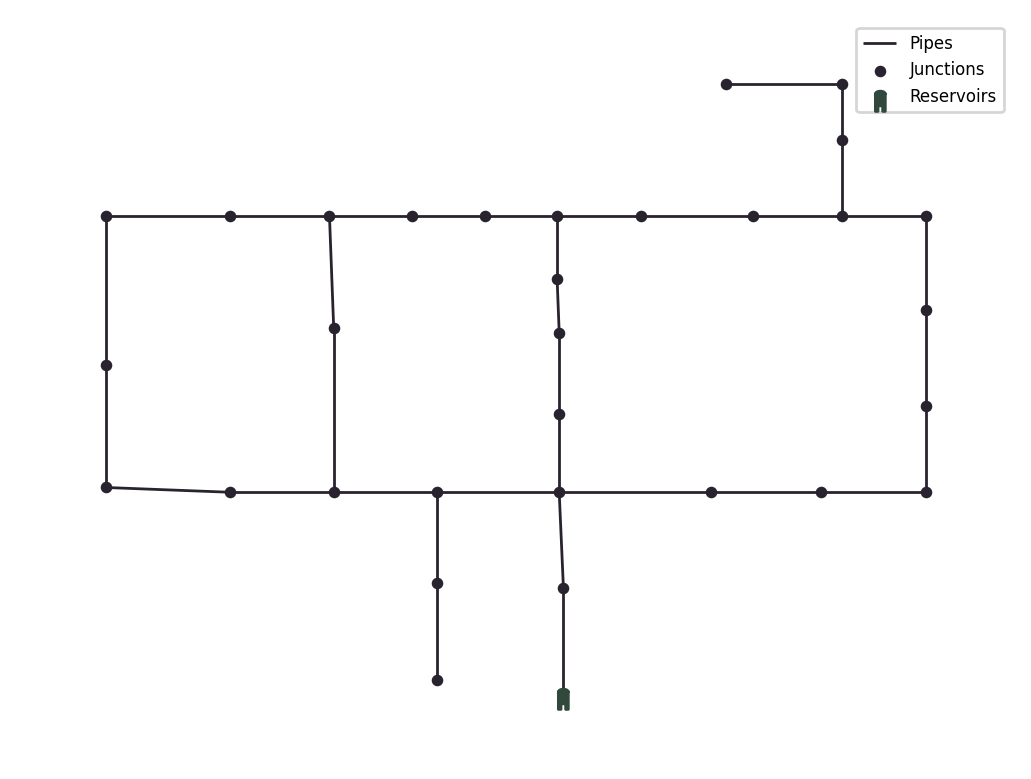

In [73]:
scenarios[scen_keys[0]].plot_topology()

### 2. Add Leakages to the Scenario

In this example, we build a scenario with two leakages: A small abrupt leakage and a large incipient leakage in the second week:

In [74]:
'''
# unnecessary, as we are using the default parameters of the scenario leaks
leak1 = AbruptLeakage(link_id="6", diameter=0.002,
                      start_time=to_seconds(days=7),
                      end_time=to_seconds(days=8))
scenario.add_leakage(leak1)

leak2 = IncipientLeakage(link_id="19", diameter=0.1,
                         start_time=to_seconds(days=11),
                         end_time=to_seconds(days=13),
                         peak_time=to_seconds(days=12))
scenario.add_leakage(leak2)
'''

'\n# unnecessary, as we are using the default parameters of the scenario leaks\nleak1 = AbruptLeakage(link_id="6", diameter=0.002,\n                      start_time=to_seconds(days=7),\n                      end_time=to_seconds(days=8))\nscenario.add_leakage(leak1)\n\nleak2 = IncipientLeakage(link_id="19", diameter=0.1,\n                         start_time=to_seconds(days=11),\n                         end_time=to_seconds(days=13),\n                         peak_time=to_seconds(days=12))\nscenario.add_leakage(leak2)\n'

Run the complete simulation:

In [75]:
scada_data = {}
for key, scenario in scenarios.items():
    scada_data[key] = scenario.run_simulation(verbose=True)

Running EPANET ...


Time steps: 100%|#########9| 17520/17521 [00:08<00:00, 2150.66it/s]


Running EPANET ...


Time steps: 100%|#########9| 17520/17521 [00:08<00:00, 2135.44it/s]


Running EPANET ...


Time steps: 100%|#########9| 17520/17521 [00:08<00:00, 2073.73it/s]


Running EPANET ...


Time steps: 100%|#########9| 17520/17521 [00:08<00:00, 2131.08it/s]


Running EPANET ...


Time steps: 100%|#########9| 17520/17521 [00:08<00:00, 2165.65it/s]


Running EPANET ...


Time steps: 100%|#########9| 17520/17521 [00:08<00:00, 2099.95it/s]


Running EPANET ...


Time steps: 100%|#########9| 17520/17521 [00:08<00:00, 2093.88it/s]


Running EPANET ...


Time steps: 100%|#########9| 17520/17521 [00:08<00:00, 2093.65it/s]


Running EPANET ...


Time steps: 100%|#########9| 17520/17521 [00:08<00:00, 2102.70it/s]


Running EPANET ...


Time steps: 100%|#########9| 17520/17521 [00:08<00:00, 2157.44it/s]


### 3. Machine Learning based Leakage Detection

Prepare the simulation results for calibrating (i.e. creating) a Machine Learning based leakage detection method:

- Create a feature vector (pressure and flow readings at the sensors).
- Create ground-truth labels utilizing the [`time_points_to_one_hot_encoding()`](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.html#epyt_flow.utils.time_points_to_one_hot_encoding) helper function.

In [76]:
# Concatenate pressure and flow readings into a single feature vector
# X = np.concatenate((scada_data.get_data_pressures(), scada_data.get_data_flows()), axis=1)
X = {key: scada_data[key].get_data_pressures()[:, sensor_placements] for key in scen_keys}  

# Build ground-truth labels -- i.e. indicator of events
y = {}
for i, scenario in enumerate(scen_keys):
    events_times = [int(t / configs[i].general_params["hydraulic_time_step"])
                for t in scenarios[scenario].get_events_active_time_points()]
    y[scenario] = time_points_to_one_hot_encoding(events_times, total_length=X[scenario].shape[0])

the following three

Split the data into train and test set -- here, training data is the fault-free first week of the simulation and the second week (containing the leakages) is the test data:

In [77]:
X_train, y_train, X_test, y_test = [], [], {}, {}
for i, key in enumerate(scen_keys):
    if i< len(scen_keys) * 0.8:  # 80% for training
        X_train.append(X[key])
        y_train.append(y[key])
    else:  # 20% for testing
        X_test[key] = X[key]
        y_test[key] = y[key]
X_train = np.vstack(X_train)        # shape → (total_samples, n_features)
y_train = np.concatenate(y_train)   # shape → (total_samples,)
#split_point = 2000
#X_train, y_train = X[:split_point, :], y[:split_point]
#X_test, y_test = X[split_point:, :], y[split_point:]
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (140168, 15)
y_train shape: (140168,)


#### Machine Learning based Event Detector


As a classic baseline, EPyT-Flow already implements a residual-based interpolation detection method called [`SensorInterpolationDetector`](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.models.html#epyt_flow.models.sensor_interpolation_detector.SensorInterpolationDetector).

This method tries to predict the readings of a given sensor based on all other sensors: $f: \vec{x}_t\setminus\{i\} \mapsto (\vec{x}_t)_i$, where $\vec{x}_t$ refers to these sensor ratings at time $t$, and $\vec{x}_t\setminus\{i\}$ denotes these sensor readings without the $i$-th sensor.
An alarm is raised (i.e. event detected) whenever the prediction and the observation of at least one sensor differ significantly:
$$
   \exists i:\; |f(\vec{x}_t\setminus\{i\}) - (\vec{x}_t)_i| > \theta_i
$$
where $\theta_i > 0$ denotes a sensor-specific threshold at which the difference is considered as significant.
For this, the detection method has to be calibrated (i.e. fitted) to a time window of (ideally event-free) sensor readings to determine a suitable threshold $\theta$ that does not raise an alarm when the network is in normal operation (i.e. no events present).

We use this event detector to detect leakages in our generated scenario.
We create and calibrate (i.e. fit) the leakage detector to the first week of simulated data:

In [78]:
detector = SensorInterpolationDetector()
mixed_clf = mixed_model_classification_fit(50, X_train, y_train)

detector.fit(X_train)

KeyboardInterrupt: 

Apply the detector to the test data (i.e. second week of simulated data):

In [ ]:
#suspicious_time_points = detector.apply(X_test)
suspicious_time_points = mixed_model_classification_predict(mixed_clf, X_test[scen_keys[8]], y_test[scen_keys[9]])
y_test_pred = time_points_to_one_hot_encoding(suspicious_time_points, X_test[scen_keys[8]].shape[0])

              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00     17521

    accuracy                           1.00     17521
   macro avg       1.00      1.00      1.00     17521
weighted avg       1.00      1.00      1.00     17521



### 4. Evaluation

In order to evaluate the performance of the leakage detector, we could either compute the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) or plot the raised alarms together with the ground truth labels.

Here, we plot event (i.e. leakage) presence over time together with the raised alarms by the detector:

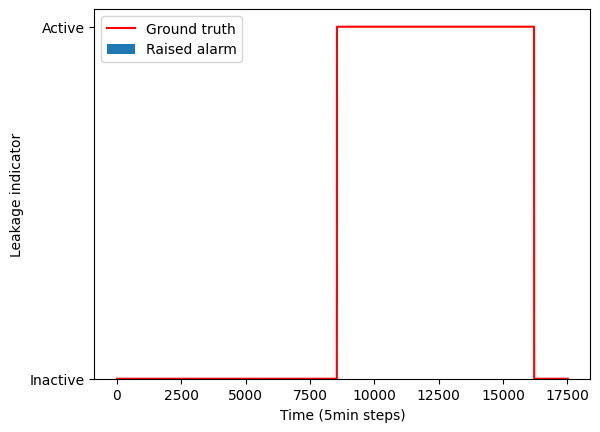

In [ ]:
plt.figure()
plt.plot(list(range(len(y_test[scen_keys[8]]))), y_test[scen_keys[8]], color="red", label="Ground truth")
plt.bar(list(range(len(y_test_pred))), y_test_pred, label="Raised alarm")
plt.legend()
plt.ylabel("Leakage indicator")
plt.yticks([0, 1], ["Inactive", "Active"])
plt.xlabel("Time (5min steps)")
plt.show()

We observe that the small abrupt leakage is not detected, while the large incipient leakage is detected -- only a single false alarm is raised.

**Note:** More advanced algorithms & methods are likely to show a better detection performance.

### Close the Simulation

Do not forget to close the simulation:

In [ ]:
for scenario in scenarios.values():
    scenario.close()